<h1>📦 Importing Required Libraries<h1>
<h5>This section imports essential libraries for random number generation, numerical operations, data handling, and visualization.<h5>

In [29]:
import random  # For generating random numbers and making random choices
import numpy as np  # For numerical operations and array handling
from collections import defaultdict  # For creating dictionaries with default values
import matplotlib.pyplot as plt  # For plotting and visualizing data

<h1>🌍 Defining the GridWorld Environment<h1>
<h5>This class implements a simple GridWorld environment where an agent starts at the bottom row, tries to reach the gold (reward), and avoid the bomb (penalty), while actions have a probabilistic outcome.<h5>

In [30]:
class GridWorldEnv:
    def __init__(self, height=5, width=5):
        """
        Initialize the GridWorld environment.
        - height: number of rows in the grid
        - width: number of columns in the grid
        - actions: possible movement directions (UP, DOWN, LEFT, RIGHT)
        - action_probs: [0.8, 0.2] meaning 80% intended direction, 20% random other direction
        """
        self.height = height
        self.width = width
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        self.action_probs = [0.8, 0.2]
        self.reset()

    def reset(self):
        """
        Reset the environment to the start of a new episode.
        - Places the agent at a random cell in the bottom row.
        - Sets the locations of the gold and the bomb.
        """
        self.starting_positions = [(self.height - 1, i) for i in range(self.width)]
        self.agent_pos = random.choice(self.starting_positions)

        self.gold_pos = (0, self.width - 1)  # Gold is in the top-right corner
        self.bomb_pos = (0, 0)  # Bomb is in the top-left corner

        # Return the initial agent position
        return self.agent_pos

    def get_available_actions(self):
        # Return the list of all possible actions (directions) the agent can take.
        return self.actions

    def agent_on_map(self):

        # Create a grid and initialize it with '.' representing empty spaces
        grid = [['.' for _ in range(self.width)] for _ in range(self.height)]

        # Mark the agent's position with 'A'
        x, y = self.agent_pos
        grid[x][y] = 'A'

        # Print the grid row by row
        for row in grid:
            print(' '.join(row))

    def get_reward(self, pos):
        """
        Get the reward associated with a given position in the grid.
        - Gold gives +10
        - Bomb gives -10
        - All other positions give -1 (penalty for movement)
        """
        if pos == self.gold_pos:
            return +10  # Reward for reaching the gold
        elif pos == self.bomb_pos:
            return -10  # Penalty for stepping on the bomb
        else:
            return -1  # Penalty for just moving to another spot

    def make_step(self, action):
        """
        Perform a move in the environment based on the agent's chosen action.
        - 80% chance of moving in the intended direction.
        - 20% chance of moving in a random direction.
        - Returns the reward after the move.
        """

        intended_action = action
        if random.random() > self.action_probs[0]:
            intended_action = random.choice([a for a in self.actions if a != action])

        # Get the current position of the agent
        x, y = self.agent_pos
        new_x, new_y = x, y

        # Update the agent's position based on the action (if within grid bounds)
        if intended_action == 'UP' and x > 0:
            new_x -= 1
        elif intended_action == 'DOWN' and x < self.height - 1:
            new_x += 1
        elif intended_action == 'LEFT' and y > 0:
            new_y -= 1
        elif intended_action == 'RIGHT' and y < self.width - 1:
            new_y += 1

        # The new position after the move
        new_pos = (new_x, new_y)

        # Get the reward associated with the new position
        reward = self.get_reward(new_pos)

        # Update the agent's position to the new position
        self.agent_pos = new_pos

        # Return the reward for this step
        return reward

    def check_state(self):
        """
        Check if the agent is in a terminal state.
        A terminal state occurs when the agent is at the position of the gold or bomb.
        Returns True if the agent is on the gold or bomb, otherwise False.
        """
        # The agent reaches a terminal state if it is on gold or bomb
        return self.agent_pos in [self.gold_pos, self.bomb_pos]


<h1>🎲 Defining a Random Agent<h1>
<h5>This class defines a simple agent that selects actions completely at random, without learning or using any strategy.<h5>

In [31]:
class RandomAgent:
    """
    A simple agent that chooses actions uniformly at random from the set of available actions.
    This agent does not learn from experience and follows no specific strategy.
    """

    def choose_action(self, available_actions):
        """
        Selects and returns a random action from the list of available actions.

        Parameters:
        - available_actions (list): The actions that the agent can currently take.

        This list is provided by the environment and can include actions like 'UP', 'DOWN', 'LEFT', 'RIGHT', etc.

        Returns:
        - action (str): A randomly selected action from the available actions.

        The agent randomly selects one of the available actions and returns it as the chosen action.
        """
        # Select and return a random action from the available actions
        return random.choice(available_actions)


<h1>🧠 Defining a Q-Learning Agent<h1>
<h5>This class implements a Q-learning agent that learns an optimal policy for navigating the GridWorld environment by updating Q-values based on experience.<h5>

In [32]:
class QAgent:
    """
    An agent that uses the Q-learning algorithm to learn an optimal policy for navigating
    the GridWorld environment.

    Q-learning is an off-policy temporal difference learning algorithm that estimates the
    optimal action-value function (Q-values) for state-action pairs.
    """

    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1.0):
        """
        Initialize the QAgent.

        Parameters:
        - environment: The GridWorldEnv object the agent interacts with.
        - epsilon (float): Exploration rate for ε-greedy policy (chance to pick random action).
        - alpha (float): Learning rate for Q-value updates.
        - gamma (float): Discount factor (set to 1.0 here, meaning no discounting).
        """
        self.env = environment  # Environment the agent interacts with (GridWorldEnv)
        self.epsilon = epsilon  # Exploration rate for ε-greedy policy
        self.alpha = alpha  # Learning rate (how much to update Q-values)
        self.gamma = gamma  # Discount factor (how much to value future rewards)

        # Q-table: A dictionary mapping state (position) to a dictionary of action-values (Q-values)
        # Initially, all Q-values are set to 0 for all actions in all states
        self.q_table = defaultdict(lambda: {a: 0.0 for a in self.env.get_available_actions()})

    def choose_action(self, available_actions):
        """
        Selects an action using an ε-greedy policy:
        - With probability ε, choose a random action (exploration).
        - With probability 1 - ε, choose the action with the highest Q-value (exploitation).

        Returns:
        - action (str): The selected action.
        """
        state = self.env.agent_pos  # Get the current state (the agent's position)

        if random.random() < self.epsilon:
            # Exploration: With probability ε, choose a random action
            return random.choice(available_actions)
        else:
            # Exploitation: With probability 1 - ε, choose the best action based on the current Q-values
            q_values = self.q_table[state]  # Get the Q-values for the current state
            max_q = max(q_values[a] for a in available_actions)  # Find the maximum Q-value for available actions
            # In case of multiple actions with the same max Q-value, choose randomly among them
            best_actions = [a for a in available_actions if q_values[a] == max_q]
            return random.choice(best_actions)  # Return a randomly selected best action

    def learn(self, old_state, reward, new_state, action):
        """
        Update the Q-value for a given state and action using the Q-learning formula.

        Q(s, a) ← Q(s, a) + α [r + γ * max_a' Q(s', a') - Q(s, a)]

        Parameters:
        - old_state (tuple): The state before the action was taken.
        - reward (float): The reward received after taking the action.
        - new_state (tuple): The state after the action was taken.
        - action (str): The action taken in old_state.
        """
        old_q = self.q_table[old_state][action]  # Get the current Q-value for the state-action pair
        # Find the maximum Q-value for the new state (the best possible future reward)
        max_future_q = max(self.q_table[new_state].values())

        # Q-learning update rule: update the Q-value for the state-action pair
        # old_q: current Q-value
        # reward: immediate reward
        # max_future_q: best possible Q-value for the new state
        # The formula updates Q-value by considering both immediate reward and future potential rewards
        new_q = old_q + self.alpha * (reward + self.gamma * max_future_q - old_q)

        # Update the Q-table with the new Q-value for the state-action pair
        self.q_table[old_state][action] = new_q


<h1>▶️ Running Training or Evaluation Episodes<h1>
<h5>This function simulates multiple episodes in the environment using the specified agent. It supports both training (learn=True) and evaluation (learn=False) modes.<h5>

In [33]:
def run(environment, agent, trials=1000, max_steps_per_episode=100, learn=False):
    # List to store the cumulative rewards for each trial
    total_rewards = []

    # Loop over the number of trials (experiments)
    for trial in range(trials):
        # Reset the environment to the initial state at the beginning of each trial
        state = environment.reset()

        # Initialize the cumulative reward for this trial
        cumulative_reward = 0

        # Initialize the step counter for the current episode
        step = 0

        # A flag to indicate whether the game is over (for ending the loop)
        game_over = False

        # Run the episode until we hit the max steps or the game is over
        while step < max_steps_per_episode and not game_over:
            # Store the agent's position/state before taking an action
            old_state = environment.agent_pos

            # Get the available actions that the agent can take in the current state
            actions = environment.get_available_actions()

            # The agent chooses an action based on the available actions
            action = agent.choose_action(actions)

            # Execute the chosen action in the environment and receive the reward
            reward = environment.make_step(action)

            # Get the new state (position of the agent after the action)
            new_state = environment.agent_pos

            # Add the reward of this step to the cumulative reward
            cumulative_reward += reward

            # If learning is enabled and the agent is an instance of QAgent,
            # the agent will update its knowledge based on the current state-action pair
            if learn and isinstance(agent, QAgent):
                agent.learn(old_state, reward, new_state, action)

            # Check if the environment has reached a terminal state (game over)
            if environment.check_state():
                game_over = True

            # Increment the step counter for this episode
            step += 1

        # Append the cumulative reward of this trial to the total rewards list
        total_rewards.append(cumulative_reward)

    # Return the list of cumulative rewards for each trial
    return total_rewards


<h1>📊 Running and Comparing Agents<h1>
<h5>This function runs both a random agent and a Q-learning agent for a specified number of trials and plots their performance over time.<h5>

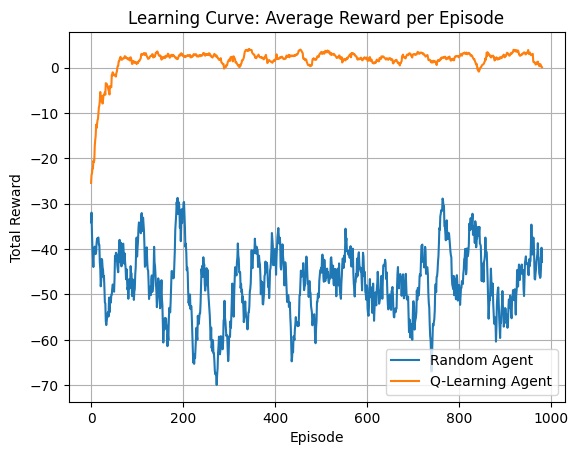

In [35]:
# Function to smooth the data by averaging over a window of size `window_size`
def smooth(data, window_size=20):
    # Using convolution to calculate the moving average of the rewards
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def main():
    # Create an environment of size 5x5 (height x width) for the agents to interact with
    env = GridWorldEnv(height=5, width=5)

    # Create a random agent and a Q-learning agent
    random_agent = RandomAgent()  # Random Agent makes decisions randomly
    q_agent = QAgent(environment=env, epsilon=0.05, alpha=0.1, gamma=1.0)  # Q-Learning agent with specific parameters

    # Run the Random Agent for 500 trials
    random_rewards = run(env, random_agent, trials=1000)

    # Run the Q-Learning Agent for 500 trials, allowing learning
    q_rewards = run(env, q_agent, trials=1000, learn=True)

    # Plot the rewards for both agents after smoothing to make the graph clearer
    # Smooth the rewards for each agent to make the curve easier to interpret
    plt.plot(smooth(random_rewards), label='Random Agent')
    plt.plot(smooth(q_rewards), label='Q-Learning Agent')

    # Title and labels for the plot
    plt.title("Learning Curve: Average Reward per Episode")
    plt.xlabel("Episode")  # X-axis represents the episode number
    plt.ylabel("Total Reward")  # Y-axis represents the total reward earned in each episode

    # Display a legend to distinguish between the agents' curves
    plt.legend()
    plt.grid(True)  # Enable grid for better visibility
    # Show the plot
    plt.show()

# Ensure the main function runs when the script is executed directly
if __name__ == "__main__":
    main()
